In [1]:
import os
import glob

import datetime as dt
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from scipy.ndimage import zoom, distance_transform_edt, generic_filter, median_filter, gaussian_filter
import cmocean.cm as cm
from cartopy.crs import NorthPolarStereo, LambertAzimuthalEqualArea, Globe
from scipy.interpolate import RegularGridInterpolator

import numpy as np
import scipy as sp
import scipy.ndimage
from tqdm import tqdm

%matplotlib inline

In [2]:
def fill_gaps_nn(array, distance=2, mask=None):
    """ Fill gaps in input array
    # https://stackoverflow.com/questions/5551286/filling-gaps-in-a-numpy-array/9262129#9262129
    Parameters
    ----------
    array : 2D numpy.array
        Raster with data
    distance : int
        Minimum size of gap to fill
    mask : 2D numpy.array
        Raster with True where to fill gaps
    Returns
    -------
    array : 2D numpy.array
        Raster with data with gaps filled
    """
    if mask is None:
        mask = np.isnan(array)
    dist, indi = distance_transform_edt(mask, return_distances=True, return_indices=True)
    gpi = dist <= distance
    r, c = indi[:, gpi]
    array = np.array(array)
    array[gpi] = array[r, c]
    return array

def gaussian_filter_nan(a, sigma, truncate):
    b = a.copy()
    b[np.isnan(a)]=0
    bb = gaussian_filter(b, sigma=sigma, truncate=truncate)

    w = np.ones_like(b)
    w[np.isnan(b)] = 0
    ww = gaussian_filter(w, sigma=sigma, truncate=truncate)

    return bb / ww

def filter_3d_array(array, ice_mask, distance=5, gauss_filter_kernel=(0.5, 1., 1.), truncate=2):
    mask = np.isnan(array)
    dist, indi = distance_transform_edt(mask, return_distances=True, return_indices=True)
    gpi = dist <= distance
    r,c,i = indi[:, gpi]
    array_f1 = np.array(array)
    array_f1[gpi] = array[r,c,i]
    array_f2 = gaussian_filter(array_f1, gauss_filter_kernel, truncate=truncate)
    array_f2[ice_mask] = np.nan
    return array_f2

In [3]:
osi_sid_dir = '/Data/sim/data/OSISAF_ice_drift'
ifiles = sorted(glob.glob(f'{osi_sid_dir}/202[0-3]/??/*.nc'))
print(len(ifiles), ifiles[0], ifiles[-1])

1264 /Data/sim/data/OSISAF_ice_drift/2020/01/ice_drift_nh_polstere-625_multi-oi_201912301200-202001011200.nc /Data/sim/data/OSISAF_ice_drift/2023/06/ice_drift_nh_polstere-625_multi-oi_202306101200-202306121200.nc


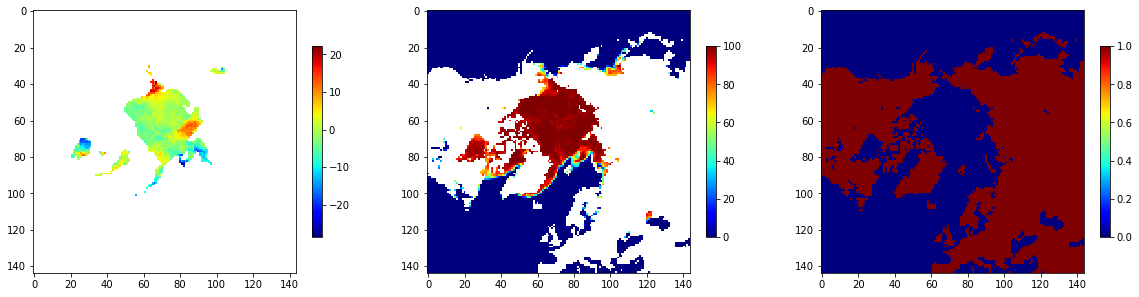

In [4]:
sid_file = '/Data/sim/data/OSISAF_ice_drift_CDR_v1p0_merged/2020/12/ice_drift_nh_ease2-750_cdr-v1p0_24h-202012301200.nc'
sic_file1 = '/Data/sim/data/OSISAF_ice_conc_CDR/2020/12/ice_conc_nh_ease2-250_icdr-v2p0_202012311200.nc'

with Dataset(sic_file1) as dds:
    sic_dst = dds['ice_conc'][0]
    status_flag = dds['status_flag'][0]
    sic_x_dst = dds['xc'][:] * 1000
    sic_y_dst = dds['yc'][:] * 1000
    
with Dataset(sid_file) as dds:
    dx_dst = dds['dX'][0]
    dy_dst = dds['dY'][0]
    sid_x_dst = dds['xc'][:] * 1000
    sid_y_dst = dds['yc'][:] * 1000

srs_dst = LambertAzimuthalEqualArea(0, 90)

fig, axs = plt.subplots(1,3, figsize=(20,7))
plt.colorbar(axs[0].imshow(dx_dst, cmap='jet', interpolation='nearest'), ax=axs[0], shrink=0.5)
plt.colorbar(axs[1].imshow(sic_dst[1:-1:3, 1:-1:3], cmap='jet', clim=[0, 100], interpolation='nearest'), ax=axs[1], shrink=0.5)
plt.colorbar(axs[2].imshow(status_flag[1:-1:3, 1:-1:3] % 2 == 1, cmap='jet', clim=[0, 1], interpolation='nearest'), ax=axs[2], shrink=0.5)
plt.show()


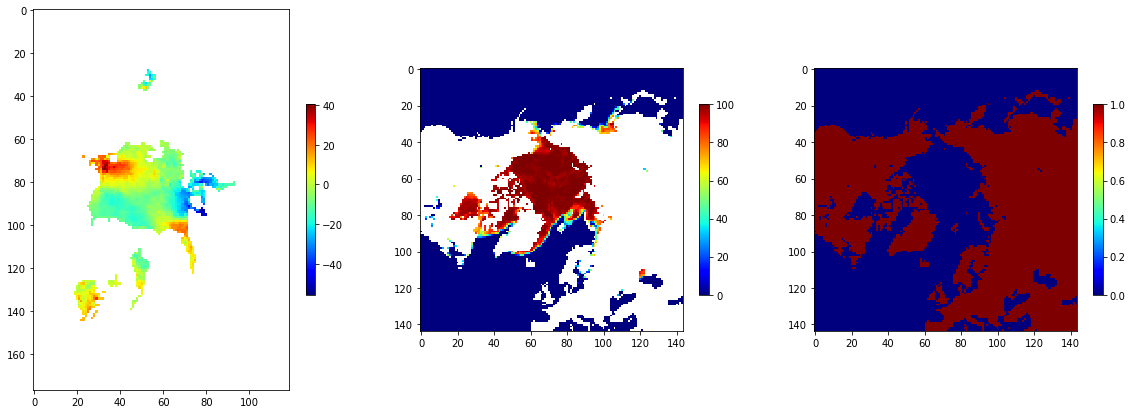

In [5]:
sid_file = '/Data/sim/data/OSISAF_ice_drift/2020/12/ice_drift_nh_polstere-625_multi-oi_202012291200-202012311200.nc'
sic_file = '/Data/sim/data/OSISAF_ice_conc/polstere/2020_nh_polstere/ice_conc_nh_polstere-100_multi_202012311200.nc'
sic_file = '/Data/sim/data/OSISAF_ice_conc_CDR/2020/12/ice_conc_nh_ease2-250_icdr-v2p0_202012311200.nc'

with Dataset(sid_file) as dds:
    dx_src = dds['dX'][0]
    dy_src = dds['dY'][0]
    x_sid = dds['xc'][:] * 1000
    y_sid = dds['yc'][:] * 1000

with Dataset(sic_file) as dds:
    sic_src = dds['ice_conc'][0]
    status_flag = dds['status_flag'][0]
    x_sic = dds['xc'][:] * 1000
    y_sic = dds['yc'][:] * 1000
    
srs_sid = NorthPolarStereo(-45, 70)
srs_sic = NorthPolarStereo(-45, 70)
    
fig, axs = plt.subplots(1,3, figsize=(20,7))
plt.colorbar(axs[0].imshow(dx_src, cmap='jet', interpolation='nearest'), ax=axs[0], shrink=0.5)
plt.colorbar(axs[1].imshow(sic_src[1:-1:3, 1:-1:3], cmap='jet', clim=[0, 100], interpolation='nearest'), ax=axs[1], shrink=0.5)
plt.colorbar(axs[2].imshow(status_flag[1:-1:3, 1:-1:3] % 2 == 1, cmap='jet', clim=[0, 1], interpolation='nearest'), ax=axs[2], shrink=0.5)
plt.show()


In [6]:
sid_x_dst_grd, sid_y_dst_grd = np.meshgrid(sid_x_dst, sid_y_dst)
tmp = srs_sid.transform_points(srs_dst, sid_x_dst_grd, sid_y_dst_grd)
sid_x_dst_grd_sid, sid_y_dst_grd_sid = tmp[:,:,0], tmp[:,:,1]

# rotate vectors
# rotate vectors and convert to km/day drift
am = np.array([
    [np.cos(np.radians(-45)), -np.sin(np.radians(-45))],
    [np.sin(np.radians(-45)),  np.cos(np.radians(-45))],
])

dx_src_rot = (dx_src * am[0,0] + dy_src * am[0,1]) / 2
dy_src_rot = (dx_src * am[1,0] + dy_src * am[1,1]) / 2

# Prepare interpolators for thickness and concentration
rgi_dx = RegularGridInterpolator((y_sid[::-1], x_sid), dx_src_rot[::-1], method='nearest', bounds_error=False)
rgi_dy = RegularGridInterpolator((y_sid[::-1], x_sid), dy_src_rot[::-1], method='nearest', bounds_error=False)

# Do interpolation from SRC grid onto DST grid
dx_src_dst = rgi_dx((sid_y_dst_grd_sid, sid_x_dst_grd_sid))
dy_src_dst = rgi_dy((sid_y_dst_grd_sid, sid_x_dst_grd_sid))


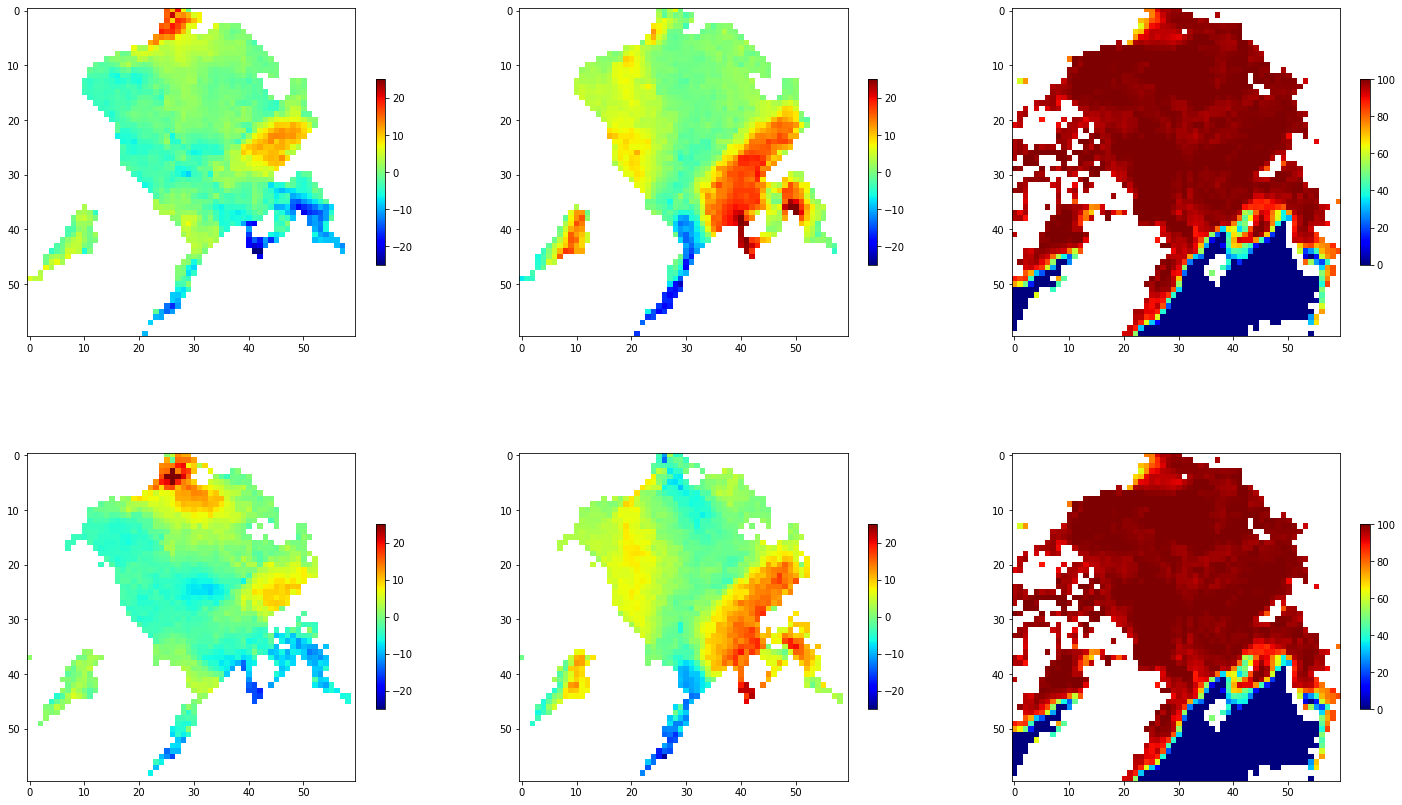

In [7]:
r0, r1, c0, c1 = 40, 100, 40, 100
clim=[-25, 25]
fig, axs = plt.subplots(2,3, figsize=(25,15))
plt.colorbar(axs[0,0].imshow(dx_dst[r0:r1, c0:c1], cmap='jet', interpolation='nearest', clim=clim), ax=axs[0,0], shrink=0.5)
plt.colorbar(axs[0,1].imshow(dy_dst[r0:r1, c0:c1], cmap='jet', interpolation='nearest', clim=clim), ax=axs[0,1], shrink=0.5)
plt.colorbar(axs[0,2].imshow(sic_dst[1:-1:3, 1:-1:3][r0:r1, c0:c1], cmap='jet', clim=[0, 100], interpolation='nearest'), ax=axs[0,2], shrink=0.5)

plt.colorbar(axs[1,0].imshow(dx_src_dst[r0:r1, c0:c1], cmap='jet', interpolation='nearest', clim=clim), ax=axs[1,0], shrink=0.5)
plt.colorbar(axs[1,1].imshow(dy_src_dst[r0:r1, c0:c1], cmap='jet', interpolation='nearest', clim=clim), ax=axs[1,1], shrink=0.5)
plt.colorbar(axs[1,2].imshow(sic_src[1:-1:3, 1:-1:3][r0:r1, c0:c1], cmap='jet', clim=[0, 100], interpolation='nearest'), ax=axs[1,2], shrink=0.5)

plt.show()


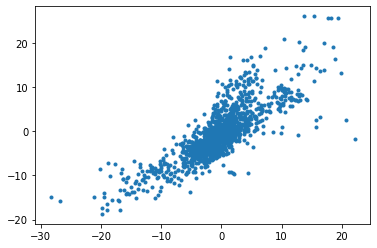

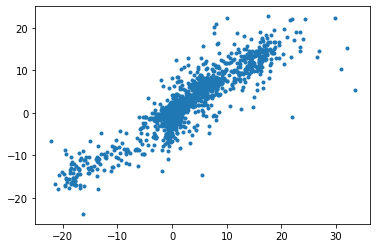

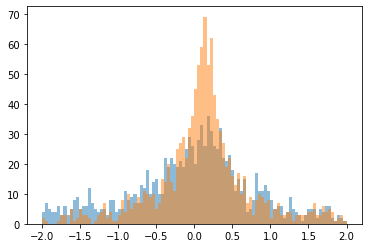

In [8]:
gpi = np.isfinite(dx_dst*dx_src_dst)
diff_dx = (dx_dst[gpi] - dx_src_dst[gpi])/dx_dst[gpi]
diff_dy = (dy_dst[gpi] - dy_src_dst[gpi])/dy_dst[gpi]

plt.plot(dx_dst[gpi], dx_src_dst[gpi], '.');plt.show()
plt.plot(dy_dst[gpi], dy_src_dst[gpi], '.');plt.show()
plt.hist(diff_dx, 100, [-2, 2], alpha=0.5)
plt.hist(diff_dy, 100, [-2, 2], alpha=0.5)
plt.show()

In [9]:
# dates for processing
min_date = dt.datetime(2020,12,1)
max_date = dt.datetime(2023,6,1)
dates = [min_date + dt.timedelta(i) for i in range((max_date - min_date).days)]
print(len(dates), dates[0], dates[-1])

912 2020-12-01 00:00:00 2023-05-31 00:00:00


In [10]:
# READ ALL SID DATA (WITH ROTATION and REPROJECTION)
def get_sid405_on_laea(sid_file):
    with Dataset(sid_file) as dds:
        dx_src = dds['dX'][0]
        dy_src = dds['dY'][0]
    dx_src_rot = (dx_src * am[0,0] + dy_src * am[0,1]) / 2
    dy_src_rot = (dx_src * am[1,0] + dy_src * am[1,1]) / 2
    rgi_dx = RegularGridInterpolator(
        (y_sid[::-1], x_sid), dx_src_rot[::-1], method='nearest', bounds_error=False)
    rgi_dy = RegularGridInterpolator(
        (y_sid[::-1], x_sid), dy_src_rot[::-1], method='nearest', bounds_error=False)
    dx_src_dst = rgi_dx((sid_y_dst_grd_sid, sid_x_dst_grd_sid))
    dy_src_dst = rgi_dy((sid_y_dst_grd_sid, sid_x_dst_grd_sid))

    return dx_src_dst, dy_src_dst

sid_dir = '/Data/sim/data/OSISAF_ice_drift'
    
all_sid_files = sorted(glob.glob(f'{sid_dir}/202[0-3]/??/*.nc'))
all_sid_dates = [f.split('-')[-1][:8] for f in all_sid_files]
print(len(all_sid_dates), all_sid_dates[0], all_sid_dates[-1])

sid_files = []
for date in dates:
    end_date_str = (date + dt.timedelta(1)).strftime('%Y%m%d')
    file_idx = all_sid_dates.index(end_date_str)
    sid_files.append(all_sid_files[file_idx])

print(len(sid_files), sid_files[0], sid_files[-1])

ddx = []
ddy = []

for sid_file in tqdm(sid_files):
    dx, dy = get_sid405_on_laea(sid_file)
    ddx.append(dx.filled(np.nan))
    ddy.append(dy.filled(np.nan))

ddx = np.array(ddx)
ddy = np.array(ddy)


1264 20200101 20230612
912 /Data/sim/data/OSISAF_ice_drift/2020/12/ice_drift_nh_polstere-625_multi-oi_202011301200-202012021200.nc /Data/sim/data/OSISAF_ice_drift/2023/05/ice_drift_nh_polstere-625_multi-oi_202305301200-202306011200.nc


100%|██████████| 912/912 [00:23<00:00, 38.10it/s] 


In [13]:
#"""
# READ ALL SIC DATA
sic_file_format = '/data1/antonk/tardis/osisaf/sic_cdr_v3p0/%Y/%m/ice_conc_nh_ease2-*_%Y%m%d1200.nc'
sic_files = [date.strftime(sic_file_format) for date in dates]
print(len(sic_files), sic_files[0], sic_files[-1])
sic_all = {}
#siu_all = {}

for sic_file, date in tqdm(zip(sic_files, dates)):
    if date in sic_all:
        continue
    match_files = glob.glob(sic_file)
    if len(match_files) > 0:
        with Dataset(match_files[0]) as dds:
            conc = dds['ice_conc'][0]
            #unce = dds['total_standard_uncertainty'][0]
    else:
        raise ValueError(f'Not existing! {sic_file}')
    sic_all[date] = conc
    #siu_all[date] = unce
si_con = np.array([sic_all[date] for date in dates])
#si_unc = np.array([siu_all[date] for date in dates])
si_con[si_con < 0] = np.nan
#si_unc[si_unc < 0] = np.nan
print(si_con.shape)

912 /data1/antonk/tardis/osisaf/sic_cdr_v3p0/2020/12/ice_conc_nh_ease2-*_202012011200.nc /data1/antonk/tardis/osisaf/sic_cdr_v3p0/2023/05/ice_conc_nh_ease2-*_202305311200.nc


912it [00:15, 60.79it/s]


(912, 432, 432)


In [11]:
"""
# READ ALL SIC DATA (WITH REPROJECTION)
sic_dir = '/Data/sim/data/OSISAF_ice_conc/polstere'
all_sic_files = sorted(glob.glob(f'{sic_dir}/202[0-3]*/ice_conc_nh_polstere-100_multi*.nc'))
print(len(all_sic_files), all_sic_files[0], all_sic_files[-1])
all_sic_dates = [f.split('_')[-1][:8] for f in all_sic_files]
print(len(all_sic_dates), all_sic_dates[0], all_sic_dates[-1])
sic_files = []
for date in dates:
    end_date_str = date.strftime('%Y%m%d')
    file_idx = all_sic_dates.index(end_date_str)
    sic_files.append(all_sic_files[file_idx])
print(len(sic_files), sic_files[0], sic_files[-1])


def get_sic401_on_laea(sic_file):
    with Dataset(sic_file) as dds:
        sic_src = dds['ice_conc'][0]
    rgi_sic = RegularGridInterpolator((y_sic[::-1], x_sic), sic_src[::-1], method='nearest', bounds_error=False)
    return rgi_sic((sic_y_dst_grd_sic, sic_x_dst_grd_sic))

si_con = [get_sic401_on_laea(sic_file).filled(np.nan) for sic_file in tqdm(sic_files)]
si_con = np.array(si_con)
"""

1259 /Data/sim/data/OSISAF_ice_conc/polstere/2020_nh_polstere/ice_conc_nh_polstere-100_multi_202001011200.nc /Data/sim/data/OSISAF_ice_conc/polstere/2023_nh_polstere/ice_conc_nh_polstere-100_multi_202306121200.nc
1259 20200101 20230612
912 /Data/sim/data/OSISAF_ice_conc/polstere/2020_nh_polstere/ice_conc_nh_polstere-100_multi_202012011200.nc /Data/sim/data/OSISAF_ice_conc/polstere/2023_nh_polstere/ice_conc_nh_polstere-100_multi_202305311200.nc


100%|██████████| 912/912 [01:32<00:00,  9.81it/s]


In [14]:
# filter data without noise
# mask by low concentration
# remove concentration, where ice drift is not given
min_sic = 15
distance = 10
#ice_mask = (si_con < min_sic) + np.isnan(si_con)
ice_mask = (si_con[:, 1:-1:3, 1:-1:3] < min_sic) + np.isnan(si_con[:, 1:-1:3, 1:-1:3])

ddxf00 = filter_3d_array(ddx, ice_mask, distance=distance)
ddyf00 = filter_3d_array(ddy, ice_mask, distance=distance)

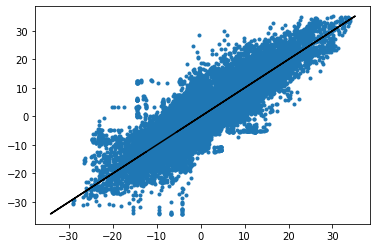

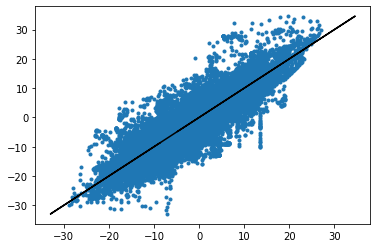

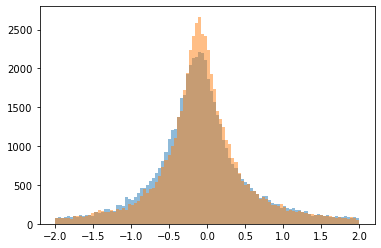

In [15]:
#"""
# TEST ON OVERLAPPING DATA
ddxf_ref = np.zeros_like(ddxf00) + np.nan
ddyf_ref = np.zeros_like(ddxf00) + np.nan

for i, ifile in enumerate(sorted(glob.glob('/data1/antonk/tardis/osisaf/sic_cdr_v3p0/postproc/2020/ice_drift_nh_ease2-750_cdr-v1p0_24h-202012*npz'))):
    ddxf_ref[i] = np.load(ifile)['u']
    ddyf_ref[i] = -np.load(ifile)['v']
    
gpi = np.isfinite(ddxf00*ddxf_ref)
u_dif = (ddxf00[gpi] - ddxf_ref[gpi]) / ddxf_ref[gpi]
v_dif = (ddyf00[gpi] - ddyf_ref[gpi]) / ddyf_ref[gpi]
plt.plot(ddxf00[gpi], ddxf_ref[gpi], '.');plt.plot(ddxf_ref[gpi], ddxf_ref[gpi], 'k-');plt.show()
plt.plot(ddyf00[gpi], ddyf_ref[gpi], '.');plt.plot(ddyf_ref[gpi], ddyf_ref[gpi], 'k-');plt.show()
plt.hist(u_dif, 100, [-2, 2], alpha=0.5)
plt.hist(v_dif, 100, [-2, 2], alpha=0.5)
plt.show()    
#"""

In [16]:
# save exactly the same format as v1pre
# for a given range of dates
# note the SIGN in np.savez(..., -ddyf00, ...)

odir = '/data1/antonk/tardis/osisaf/sic_cdr_v3p0/postproc'
save_min_date = dt.datetime(2021,1,1)
save_max_date = dt.datetime(2023,6,1)
save_dates = [save_min_date + dt.timedelta(i) for i in range((save_max_date - save_min_date).days)]

for i, date in tqdm(enumerate(dates), total=len(dates)):
    if date in save_dates:
        osubdir = date.strftime(f'{odir}/%Y')
        os.makedirs(osubdir, exist_ok=True)
        ofile = f'{osubdir}/ice_drift_nh_ease2-750_cdr-v1p0_24h-{date.strftime("%Y%m%d")}1200.nc.npz'
        #print(date, ofile)
        np.savez(ofile, u=ddxf00[i], v=-ddyf00[i], c=si_con[i])


100%|██████████| 912/912 [00:02<00:00, 376.98it/s]
